**Deep Learning For Healthcare - Final Project**

**Team 170 (Noah Slocum)**

**GitHub Repo: https://github.com/slocum2/DL4H_Project**

**Video Presentation:** See https://github.com/slocum2/DL4H_Project/blob/main/README.md


# Introduction

### Paper citation
Feng, YH., Zhang, SW. & Shi, JY. DPDDI: a deep predictor for drug-drug interactions. BMC Bioinformatics 21, 419 (2020). https://doi.org/10.1186/s12859-020-03724-x

https://github.com/NWPU-903PR/DPDDI

### Background

Understanding drug-drug interactions (DDIs) is important to developing any new medication or combinatorial prescription. Medications are frequently prescribed together for desired synergistic effects that may be greater than the effect of either medication alone. On the contrary, taking two medications simultaneously can also be dangerous if they interact to produce undesired or even toxic effects. Traditionally, drug-drug interactions have been investigated and identified in a wet lab, which is costly and very time consuming. This is true whether in vitro or in vivo methods are used. Considering the continuously growing number of drugs available for prescription, this task is only becoming more difficult as time goes on. 

In contrast to wet-lab methods, computational methods have been used to discover DDIs in two ways: one, by finding annotated DDIs in literature, medical records, and other forms of unstructured text, and two, by predicting DDIs using machine learning and detailed descriptions of drug properties. The former is useful but cannot predict DDIs before combinatorial treatment, while the latter requires that machine learning features be carefully crafted from detailed drug characteristic data (including chemical structure, targets, ATC codes, side effects, and clinical observations). 

While the latter method is useful in many cases, detailed data about drug properties may not always be available. Drugs without complete data may not be included in DDI prediction models and thus the model may not be pragmatic enough for real scenarios where the ignored drugs can still be combinatorially prescribed. The general problem Feng et al attempt to solve is that of enhancing DDI prediction to eliminate the need for hand-crafted features and to avoid ignoring or removing drugs with incomplete data.

In this paper, Feng et al describe a 2-fold approach to solving the problem stated above. First, they use a graph convolution network (GCN) to learn the low-dimensional feature representation of each drug. Using a graph data structure along with a convolutional network captures the topological relationship of each drug to neighboring drugs. This approach is unsupervised and doesn’t require manual feature engineering or complete data for each drug. The second step is feeding the low-dimensional feature representation of each drug (created by the GCN) to a deep neural network (DNN) for DDI prediction. This is done by aggregating features representing two drugs into one feature that represents the DDI.

### Hypothesis
The hypothesis is that the specific approach described above will perform better than state-of-art DDI predictors. This hypothesis is based on the following ideas:

1. The deep learning features created by a GCN will outperform other features hand-crafted from chemical, biological or anatomical properties of drugs.
2. The GCN-created features can be aggregated to represent DDIs and then used to train a deep neural network for prediction.

### Scope of reproducibility 
The model proposed by Feng et al can be implemented with Tensorflow and Python which are open source and available to anyone. The authors do not provide any computational data such as the type of hardware used in the study, the average runtime for each epoch, or the GPU-hours consumed. Without this information, I assumed that the study can be replicated on commodity hardware in a reasonable amount of time. In this notebook I tried to recreate this study by adapting code provided by the authors at https://github.com/NWPU-903PR/DPDDI/. I attempted to adapt the code to run on more recent versions of Python, Tensorflow, and SciPy.

# Methodology

### Environment
Windows 10 Enterprise

### Python version
Python 3.9

### Dependencies/packages needed
See the requirements file at https://github.com/slocum2/DL4H_Project/blob/main/requirements.txt for all required packages.

### Computational requirements
- **Hardware**:
    - **CPU**: 12th Gen Intel(R) Core(TM) i7-12800H   2.40 GHz
    - **GPU**: NVIDIA RTX A1000 Laptop GPU (8GB GPU memory)
    - **Installed RAM**: 32 GB
    - **System type**: 64-bit operating system, x64-based processor
    - **OS**: Windows 10 Enterprise 22H2 (build 19045.4291)
- **Average runtime for each epoch**: 10 seconds
- **Number of training epochs**: 1200

# Imports

In [13]:
from __future__ import division
from __future__ import print_function
import copy
import csv
import h5py
from keras import *
from keras.callbacks import Callback
from keras.models import Model
from keras.layers import Dense, Input
import matplotlib.pyplot as plt
import numpy as np
from numpy import linalg as LA
import os
import pandas as pd
from pandas import Series, DataFrame
import random
import scipy.io as sio
import scipy.sparse as sp
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
import tensorflow.compat.v1 as tf
import time

#  Data

### Download instructions
There are three datasets of different sizes used by the authors to assess the performance of their model:
- DB1: Sourced from https://go.drugbank.com/releases/latest
- DB2: vailable at https://github.com/zw9977129/drug-drug-interaction/
- DB3: Sourced from https://go.drugbank.com/releases/latest

Datasets DB1 and DB3 are available for download from the authors at https://github.com/NWPU-903PR/DPDDI/blob/master/DATA.mat. To use this data, I [installed MATLAB](https://www.mathworks.com/help/install/ug/install-products-with-internet-connection.html) and registered for a free trial. I then opened the file in MATLAB and wrote the variables inside to a HDF5 file in order to use them with the code samples from the authors. The adjacency matrix for DB1 is contained in the Adj_V4 variable, while the adjacency matrix for DB3 is contained in the Adj_V5 variable.

### Data description
The datasets used in this experiment were as follows:
- DB1: 1562 drugs and 180,576 annotated drug-drug interactions
- DB2: 548 drugs and 48,584 annotated drug-drug interactions. 
- DB3: 1934 drugs and 230,887 annotated drug-drug interactions.

Three different datasets were used by the authors in order to assess the robustness of the model. In my attempt to replicate the authors' results, I only tried using the DB1 and DB3 datasets provided by the authors to guarantee reproducibility.
The DB1 and DB3 datasets represent matrices of drug-drug interactions where 1 indicates there is an interaction where 0 indicates no interaction.

Shape: (1562, 1562)
Value: 0.0, Count: 2078692
Value: 1.0, Count: 361152


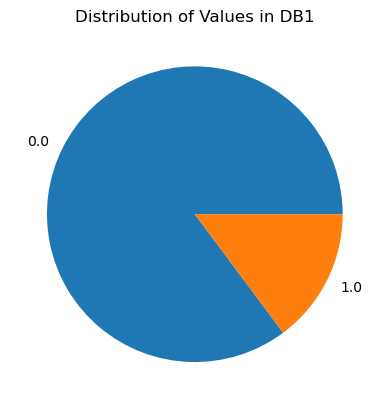

In [14]:
filename = 'data.h5'
data = h5py.File(filename,'r')
adj = data['Adj_V4'][:]
unique, counts = np.unique(adj.flatten(), return_counts=True)
counts = dict(zip(unique, counts))
print(f"Shape: {adj.shape}")
for k, v in counts.items():
 print(f"Value: {k}, Count: {v}")
plt.title('Distribution of Values in DB1')
plt.pie(counts.values(), labels=counts.keys())
plt.show()

Shape: (1934, 1934)
Value: -1.0, Count: 151980
Value: 0.0, Count: 3278582
Value: 1.0, Count: 309794


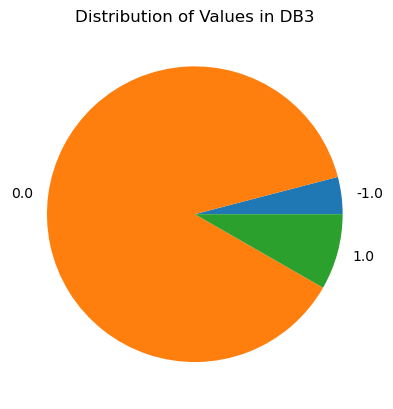

In [15]:
adj = data['Adj_V5'][:]
unique, counts = np.unique(adj.flatten(), return_counts=True)
counts = dict(zip(unique, counts))
print(f"Shape: {adj.shape}")
for k, v in counts.items():
 print(f"Value: {k}, Count: {v}")
plt.title('Distribution of Values in DB3')
plt.pie(counts.values(), labels=counts.keys())
plt.show()

### Preprocessing code

In [ ]:
adj = adj.transpose()
adj_copy = copy.deepcopy(adj)
adj = sp.csr.csr_matrix(adj)

adj_orig = adj
adj_orig = adj_orig - sp.dia_matrix((adj_orig.diagonal()[np.newaxis,:], [0]), shape=adj_orig.shape)
adj_orig.eliminate_zeros()

#   Model

The following is a diagram representing the DPDDI model. The main steps are as follows: 
1. The feature extractor of DPDDI constructs a two-layer graph convolutional network (GCN) to obtain drug latent features, which capture the complex relations between the drug nodes in the DDI network.
2. Each pair of drugs is represented as a feature vector by concatenating the corresponding latent features of the drugs. 
3. The feature vectors of representing the drug pairs are fed into a deep neural network to train the predictor to deduce potential DDIs.

![dpddi](https://media.springernature.com/full/springer-static/image/art%3A10.1186%2Fs12859-020-03724-x/MediaObjects/12859_2020_3724_Fig2_HTML.png)



### Hyperparameters
The following hyperparameters were used to reproduce this model:
- **Learning rate**: {0.1, 0.01, 0.001, 0.005, 0.0001}
- **Epochs**: {200, 500, 800, 1000, 1200, 1400, 1600}
- **Number of units in hidden layers 1 & 2**: {[800,512], [800,256], [800,128], [512,256], [512,128], [512,64], [256,64], [128,32]}
- **Weight for L2 loss on embedding matrix**: 0
- **Dropout rate (1 - keep probability)**: {0.01, 0.001, 0.0001, 0}

## Graph Auto Encoder (GAE)

### GAE Initializations

In [ ]:
def weight_variable_glorot1(input_dim, output_dim, name=""):
    """Create a weight variable with Glorot & Bengio (AISTATS 2010) initialization.
    """
#    tf.set_random_seed(123)
    init_range = np.sqrt(6.0 / (input_dim + output_dim))
    initial = tf.random_uniform([input_dim, output_dim], minval=-init_range,
                                maxval=init_range, dtype=tf.float32,seed = 12)
    return tf.Variable(initial, name=name)


def weight_variable_glorot2(input_dim, output_dim, name=""):
    """Create a weight variable with Glorot & Bengio (AISTATS 2010) initialization.
    """
#    tf.set_random_seed(231)
    init_range = np.sqrt(6.0 / (input_dim + output_dim))
    initial = tf.random_uniform([input_dim, output_dim], minval=-init_range,
                                maxval=init_range, dtype=tf.float32,seed = 50)
    return tf.Variable(initial, name=name)

### GAE Layers

In [ ]:
_LAYER_UIDS = {}

def get_layer_uid(layer_name=''):
    """Helper function, assigns unique layer IDs
    """
    if layer_name not in _LAYER_UIDS:
        _LAYER_UIDS[layer_name] = 1
        return 1
    else:
        _LAYER_UIDS[layer_name] += 1
        return _LAYER_UIDS[layer_name]


def dropout_sparse(x, keep_prob, num_nonzero_elems):
    """Dropout for sparse tensors. Currently fails for very large sparse tensors (>1M elements)
    """
    noise_shape = [num_nonzero_elems]
    random_tensor = keep_prob
    random_tensor += tf.random_uniform(noise_shape)
    dropout_mask = tf.cast(tf.floor(random_tensor), dtype=tf.bool)
    pre_out = tf.sparse_retain(x, dropout_mask)
    return pre_out * (1./keep_prob)


class Layer(object):
    """Base layer class. Defines basic API for all layer objects.

    # Properties
        name: String, defines the variable scope of the layer.

    # Methods
        _call(inputs): Defines computation graph of layer
            (i.e. takes input, returns output)
        __call__(inputs): Wrapper for _call()
    """
    def __init__(self, **kwargs):
        allowed_kwargs = {'name', 'logging'}
        for kwarg in kwargs.keys():
            assert kwarg in allowed_kwargs, 'Invalid keyword argument: ' + kwarg
        name = kwargs.get('name')
        if not name:
            layer = self.__class__.__name__.lower()
            name = layer + '_' + str(get_layer_uid(layer))
        self.name = name
        self.vars = {}
        logging = kwargs.get('logging', False)
        self.logging = logging
        self.issparse = False

    def _call(self, inputs):
        return inputs

    def __call__(self, inputs):
        with tf.name_scope(self.name):
            outputs = self._call(inputs)
            return outputs


class GraphConvolution(Layer):
    """Basic graph convolution layer for undirected graph without edge labels."""
    def __init__(self, input_dim, output_dim, adj, dropout=0., act=tf.nn.relu, **kwargs):
        super(GraphConvolution, self).__init__(**kwargs)
        with tf.variable_scope(self.name + '_vars'):
            self.vars['weights'] = weight_variable_glorot1(input_dim, output_dim, name="weights")
        self.dropout = dropout
        self.adj = adj
        self.act = act

    def _call(self, inputs):
        x = inputs
        x = tf.nn.dropout(x, 1-self.dropout)
        x = tf.matmul(x, self.vars['weights'])
        x = tf.sparse_tensor_dense_matmul(self.adj, x)
        outputs = self.act(x)
        self.w2 = self.vars['weights']
        return outputs,self.w2

class DeepConvolution(Layer):
    """Basic deep  layer for undirected graph without edge labels."""
    def __init__(self, input_dim, output_dim, dropout=0., act=tf.nn.relu, **kwargs):
        super(DeepConvolution, self).__init__(**kwargs)
        with tf.variable_scope(self.name + '_vars'):
            self.vars['weights'] = weight_variable_glorot2(input_dim, output_dim, name="weights2")
        self.dropout = 0.0001
        self.act = act

    def _call(self, inputs):
        x = inputs
        x = tf.nn.dropout(x, 1-self.dropout)
        x = tf.matmul(x, self.vars['weights'])
        outputs = self.act(x)
        return outputs


class GraphConvolutionSparse(Layer):
    """Graph convolution layer for sparse inputs."""
    def __init__(self, input_dim, output_dim, adj, features_nonzero, dropout=0., act=tf.nn.relu, **kwargs):
        super(GraphConvolutionSparse, self).__init__(**kwargs)
        with tf.variable_scope(self.name + '_vars'):
            self.vars['weights'] = weight_variable_glorot2(input_dim, output_dim, name="weights")
        self.dropout = dropout
        self.adj = adj
        self.act = act
        self.issparse = True
        self.features_nonzero = features_nonzero

    def _call(self, inputs):
        x = inputs
        x = dropout_sparse(x, 1-self.dropout, self.features_nonzero)
        x = tf.sparse_tensor_dense_matmul(x, self.vars['weights'])
        x = tf.sparse_tensor_dense_matmul(self.adj, x)
        outputs = self.act(x)
        w1 = self.vars['weights']
        return outputs,w1


class InnerProductDecoder(Layer):
    """Decoder model layer for link prediction."""
    def __init__(self, input_dim, dropout=0., act=tf.nn.sigmoid, **kwargs):
        super(InnerProductDecoder, self).__init__(**kwargs)
        self.dropout = dropout
        self.act = act

    def _call(self, inputs):
        inputs = tf.nn.dropout(inputs, 1-self.dropout)
        x = tf.transpose(inputs)
        x = tf.matmul(inputs, x)
        x = tf.reshape(x, [-1])
        outputs = self.act(x)
        return outputs

### GAE Model

In [ ]:
class Model(object):
    def __init__(self, **kwargs):
        allowed_kwargs = {'name', 'logging'}
        for kwarg in kwargs.keys():
            assert kwarg in allowed_kwargs, 'Invalid keyword argument: ' + kwarg

        for kwarg in kwargs.keys():
            assert kwarg in allowed_kwargs, 'Invalid keyword argument: ' + kwarg
        name = kwargs.get('name')
        if not name:
            name = self.__class__.__name__.lower()
        self.name = name

        logging = kwargs.get('logging', False)
        self.logging = logging

        self.vars = {}

    def _build(self):
        raise NotImplementedError

    def build(self):
        """ Wrapper for _build() """
        with tf.variable_scope(self.name):
            self._build()
        variables = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope=self.name)
        self.vars = {var.name: var for var in variables}

    def fit(self):
        pass

    def predict(self):
        pass


class GCNModelAE(Model):
    def __init__(self, placeholders, num_features, features_nonzero, **kwargs):
        super(GCNModelAE, self).__init__(**kwargs)

        self.inputs = placeholders['features']
        self.input_dim = num_features
        self.features_nonzero = features_nonzero
        self.adj = placeholders['adj']
        self.dropout = placeholders['dropout']
        self.build()

    def _build(self):
        self.hidden1,self.w1 = GraphConvolutionSparse(input_dim=self.input_dim,
                                              output_dim=FLAGS.hidden1,
                                              adj=self.adj,
                                              features_nonzero=self.features_nonzero,
                                              act=tf.nn.relu,
                                              dropout=self.dropout,
                                              logging=self.logging)(self.inputs)

        self.embeddings,self.w2 = GraphConvolution(input_dim=FLAGS.hidden1,
                                           output_dim=FLAGS.hidden2,
                                           adj=self.adj,
                                           act=lambda x: x,
                                           dropout=self.dropout,
                                           logging=self.logging)(self.hidden1)
        self.z_mean = self.embeddings
        self.reconstructions = InnerProductDecoder(input_dim=FLAGS.hidden2,
                                      act=lambda x: x,
                                      logging=self.logging)(self.embeddings)


class GCNModelVAE(Model):
    def __init__(self, placeholders, num_features, num_nodes, features_nonzero, **kwargs):
        super(GCNModelVAE, self).__init__(**kwargs)

        self.inputs = placeholders['features']
        self.input_dim = num_features
        self.features_nonzero = features_nonzero
        self.n_samples = num_nodes
        self.adj = placeholders['adj']
        self.dropout = placeholders['dropout']
        self.build()

    def _build(self):
        self.hidden1 = GraphConvolutionSparse(input_dim=self.input_dim,
                                              output_dim=FLAGS.hidden1,
                                              adj=self.adj,
                                              features_nonzero=self.features_nonzero,
                                              act=tf.nn.relu,
                                              dropout=self.dropout,
                                              logging=self.logging)(self.inputs)

        self.z_mean = GraphConvolution(input_dim=FLAGS.hidden1,
                                       output_dim=FLAGS.hidden2,
                                       adj=self.adj,
                                       act=lambda x: x,
                                       dropout=self.dropout,
                                       logging=self.logging)(self.hidden1)

        self.z_log_std = GraphConvolution(input_dim=FLAGS.hidden1,
                                          output_dim=FLAGS.hidden2,
                                          adj=self.adj,
                                          act=lambda x: x,
                                          dropout=self.dropout,
                                          logging=self.logging)(self.hidden1)

        self.z = self.z_mean + tf.random_normal([self.n_samples, FLAGS.hidden2]) * tf.exp(self.z_log_std)

        self.reconstructions = InnerProductDecoder(input_dim=FLAGS.hidden2,
                                      act=lambda x: x,
                                      logging=self.logging)(self.z)


### GAE Optimizer

In [ ]:
class OptimizerAE(object):
    def __init__(self, preds, labels, pos_weight, norm):#,w1,w2
        preds_sub = preds
        labels_sub = labels

        self.cost = norm * tf.reduce_mean(tf.nn.weighted_cross_entropy_with_logits(logits=preds_sub,\
                          targets=labels_sub, pos_weight=pos_weight))   #  +reg_term
        self.optimizer = tf.train.AdamOptimizer(learning_rate=FLAGS.learning_rate)  # Adam Optimizer

        self.opt_op = self.optimizer.minimize(self.cost)
        self.grads_vars = self.optimizer.compute_gradients(self.cost)

        self.correct_prediction = tf.equal(tf.cast(tf.greater_equal(tf.sigmoid(preds_sub), 0.5), tf.int32),
                                           tf.cast(labels_sub, tf.int32))
        self.accuracy = tf.reduce_mean(tf.cast(self.correct_prediction, tf.float32))


class OptimizerVAE(object):
    def __init__(self, preds, labels, model, num_nodes, pos_weight, norm):  #,w1,w2
        preds_sub = preds
        labels_sub = labels

        self.cost = norm * tf.reduce_mean(tf.nn.weighted_cross_entropy_with_logits(logits=preds_sub, targets=labels_sub, pos_weight=pos_weight))
        self.optimizer = tf.train.AdamOptimizer(learning_rate=FLAGS.learning_rate)  # Adam Optimizer

        # Latent loss
        self.log_lik = self.cost
        self.kl = (0.5 / num_nodes) * tf.reduce_mean(tf.reduce_sum(1 + 2 * model.z_log_std - tf.square(model.z_mean) -
                                                                   tf.square(tf.exp(model.z_log_std)), 1))
        self.cost -= self.kl

        self.opt_op = self.optimizer.minimize(self.cost)
        self.grads_vars = self.optimizer.compute_gradients(self.cost)

        self.correct_prediction = tf.equal(tf.cast(tf.greater_equal(tf.sigmoid(preds_sub), 0.5), tf.int32),
                                           tf.cast(labels_sub, tf.int32))
        self.accuracy = tf.reduce_mean(tf.cast(self.correct_prediction, tf.float32))


## DPDDI

### DPDDI Model

In [ ]:
def get_roc_score1(edges_pos, edges_neg,emb=None):
    if emb is None:
        feed_dict.update({placeholders['dropout']: 0})
        emb = sess.run(model.z_mean, feed_dict=feed_dict)

    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    # Predict on test set of edges
    adj_rec = np.dot(emb, emb.T)
    preds = []
    pred_probability_pos = []
    pos = []
    for e in edges_pos:
        pred_probability_pos.append(adj_rec[e[0], e[1]])
        preds.append(sigmoid(adj_rec[e[0], e[1]]))
        pos.append(adj_orig[e[0], e[1]])

    preds_neg = []
    pred_probability_neg = []
    neg = []
    for e in edges_neg:
        pred_probability_neg.append(adj_rec[e[0], e[1]])
        preds_neg.append(sigmoid(adj_rec[e[0], e[1]]))
        neg.append(adj_orig[e[0], e[1]])

    preds_all = np.hstack([preds, preds_neg])
    preds_probability_all = np.hstack([pred_probability_pos, pred_probability_neg])
    labels_all = np.hstack([np.ones(len(preds)), np.zeros(len(preds_neg))])
    roc_score = roc_auc_score(labels_all, preds_probability_all)   ## preds_all
    precision, recall, pr_thresholds = precision_recall_curve(labels_all, preds_probability_all)
    aupr_score = auc(recall, precision)   

    return roc_score, aupr_score

def get_roc_score2(pre,preds_probability_all,y_test):
   
    preds_all = np.array(pre)
    preds_probability_all = np.array(pre)
    labels_all = np.array(y_test)
    roc_score = roc_auc_score(labels_all,preds_probability_all)   
    
    precision, recall, pr_thresholds = precision_recall_curve(labels_all, preds_probability_all )  ##preds_all   preds_probability_all
    aupr_score = auc(recall, precision)
#    
    all_F_measure=np.zeros(len(pr_thresholds))
    for k in range(0,len(pr_thresholds)):
        if (precision[k]+precision[k])>0:
            all_F_measure[k]=2*precision[k]*recall[k]/(precision[k]+recall[k])
        else:
            all_F_measure[k]=0
    max_index=all_F_measure.argmax()
    threshold=pr_thresholds[max_index]
#        
    fpr, tpr, auc_thresholds = roc_curve(labels_all, preds_probability_all)
    auc_score = auc(fpr, tpr)
    predicted_score=np.zeros(shape=(len(labels_all),1))
    predicted_score[preds_probability_all>threshold]=1
    confusion_matri = confusion_matrix(y_true=labels_all, y_pred=predicted_score)
    print("confusion_matrix:",confusion_matri)
        
    f=f1_score(labels_all,predicted_score)
    accuracy=accuracy_score(labels_all,predicted_score)
    precision=precision_score(labels_all,predicted_score)
    recall=recall_score(labels_all,predicted_score)

    return roc_score, aupr_score,precision, recall,accuracy,f

def sparse_to_tuple(sparse_mx):
    if not sp.isspmatrix_coo(sparse_mx):
        sparse_mx = sparse_mx.tocoo()
    coords = np.vstack((sparse_mx.row, sparse_mx.col)).transpose()
    values = sparse_mx.data
    shape = sparse_mx.shape
    return coords, values, shape


def preprocess_graph(adj):
    adj = sp.coo_matrix(adj)
    adj_ = adj + sp.eye(adj.shape[0])
    rowsum = np.array(adj_.sum(1))
    degree_mat_inv_sqrt = sp.diags(np.power(rowsum, -0.5).flatten())
    adj_normalized = adj_.dot(degree_mat_inv_sqrt).transpose().dot(degree_mat_inv_sqrt).tocoo()
    return sparse_to_tuple(adj_normalized)


def construct_feed_dict(adj_normalized, adj, features, placeholders):
    # construct feed dictionary
    feed_dict = dict()
    feed_dict.update({placeholders['features']: features})
    feed_dict.update({placeholders['adj']: adj_normalized})
    feed_dict.update({placeholders['adj_orig']: adj})
    return feed_dict


    
def mask_test_edges(adj):
    # Remove diagonal elements
    adj = adj - sp.dia_matrix((adj.diagonal()[np.newaxis, :], [0]), shape=adj.shape)
    adj.eliminate_zeros()
    # Check that diag is zero:
    assert np.diag(adj.todense()).sum() == 0

    train_edges, train_edges_false, val_edges, val_edges_false, test_edges, test_edges_false = [],[],[],[],[],[]
    adj_train = []

    link_number = 0
    non_link_number = 0
    link_position = []
    non_link_position = []  # all non-link position
    for i in range(0, adj.shape[0]):
        for j in range(i + 1, adj.shape[1]):
            if adj[i, j] == 1:
                link_number = link_number + 1
                link_position.append([i, j])
            elif adj[i,j] ==0:
                non_link_number = non_link_number +1
                non_link_position.append([i,j])


    link_position = np.array(link_position)
    non_link_position = np.array(non_link_position)
    seed = 12
    random.seed(seed)
    link_index = np.arange(0, link_number)
    non_link_index = np.arange(0, non_link_number)
    random.shuffle(link_index)
    random.shuffle(non_link_index)
    kfold = 5
    num_train_kd = link_number// kfold
    num_test_kd = int(np.floor(num_train_kd * 0.2))
    num_val_kd = int(np.floor(num_train_kd * 0.5))   #num_train_kd / 20.
    num_negtive_kd = non_link_number // kfold
    
    for i in range(kfold):
        train_link_index = link_index[i *num_train_kd:(i+1)*num_train_kd]        
        test_link_index = train_link_index[0:num_test_kd]
        val_link_index = train_link_index[num_test_kd:num_test_kd + num_val_kd]
        train_index = train_link_index[num_test_kd + num_val_kd:num_train_kd]
        
        train_index.sort()
        val_link_index.sort()
        test_link_index.sort()       
        train_edges.append(link_position[train_index])
        val_edges.append(link_position[val_link_index])
        test_edges.append(link_position[test_link_index])
        
        fold =6
        kd_no_link_index = non_link_index[i*num_negtive_kd:(i+1)*num_negtive_kd]
        test_no_link_index = kd_no_link_index[0: fold * num_test_kd]
        val_no_link_index = kd_no_link_index[fold * num_test_kd:fold * (num_test_kd + num_val_kd)]
        train_no_link_index = kd_no_link_index[fold * (num_test_kd + num_val_kd):num_negtive_kd]
        train_no_index = train_no_link_index
        
        train_no_index.sort()
        val_no_link_index.sort()
        test_no_link_index.sort()       
        train_edges_false.append(non_link_position[train_no_index])
        val_edges_false.append(non_link_position[val_no_link_index])
        test_edges_false.append(non_link_position[test_no_link_index])
        data = np.ones(np.array(train_edges).shape[1])
        # Re-build adj matrix
        adj_train_rebuild = sp.csr_matrix((data, (np.array(train_edges)[0, :, 0], np.array(train_edges)[0, :, 1])), shape=adj.shape)
        adj_train_rebuild = adj_train_rebuild + adj_train_rebuild.T
        adj_train.append(adj_train_rebuild)
    
    return adj_train, train_edges, train_edges_false,val_edges, val_edges_false, test_edges, test_edges_false

def node_trans_edges(test_edges,test_edges_false,val_edges,val_edges_false,train_edges,train_edges_false):
    if type(test_edges) != list:
        test_edges = test_edges.tolist()
    if type(train_edges_false) != list:
        train_edges_false = train_edges_false.tolist()
    if type(train_edges) != list:
        train_edges = train_edges.tolist()
    if type(test_edges_false) != list:
        test_edges_false = test_edges_false.tolist()  
    if type(val_edges) != list:
        val_edges = val_edges.tolist() 
    if type(val_edges_false) != list:
        val_edges_false = val_edges_false.tolist() 
        
    x_train_index = train_edges + train_edges_false
    y_train = [1]*len(train_edges) + [0] * len(train_edges_false)
    x_val_index = val_edges + val_edges_false
    y_val = [1]*len(val_edges) + [0] * len(val_edges_false)
    x_test_index = test_edges + test_edges_false
    y_test = [1]*len(test_edges) + [0] * len(test_edges_false)
    x_train = []
    x_val = []
    x_test = []
    
    ###transform node embdding to edges feature by concat opration 
    t = time.time()
    for i in range(len(x_train_index)):
        x_train.append(np.hstack((embedding[ x_train_index[i][0]],embedding[ x_train_index[i][1]])))
    for i in range(len(x_val_index)):
        x_val.append(np.hstack((embedding[ x_val_index[i][0]],embedding[ x_val_index[i][1]])))
    for i in range(len(x_test_index)):
        x_test.append(np.hstack((embedding[ x_test_index[i][0]] ,embedding[ x_test_index[i][1]])))
    print("cost time of embedding concat", time.time()-t)
    
    y_train = utils.to_categorical(y_train, 2)
    y_test = utils.to_categorical(y_test, 2)
    y_val =  utils.to_categorical(y_val, 2)
    
    x_train = np.matrix(x_train)
    x_test = np.matrix(x_test)
    x_val = np.matrix(x_val)
    y_train = np.array(y_train)
    y_test = np.array(y_test)
    y_val = np.array(y_val)
    print("fill embedding data accomplishment")
    return x_train, x_test, x_val, y_train, y_test, y_val

### DPDDI Evaluator

In [ ]:
class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()
        self.interval = interval
        self.x_val,self.y_val = validation_data
    def on_epoch_end(self, epoch, log={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.x_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print('\n ROC_AUC - epoch:%d - score:%.6f \n' % (epoch+1, score))

### DPDDI Training

In [ ]:
# Settings
tf.compat.v1.disable_eager_execution()
flags = tf.compat.v1.flags
FLAGS = flags.FLAGS
FLAGS = tf.app.flags.FLAGS
try:
    flags.DEFINE_string('f','','')
except tf.compat.v1.flags.DuplicateFlagError:
    pass
try:
    flags.DEFINE_float('learning_rate', 0.001, 'Initial learning rate.')
except tf.compat.v1.flags.DuplicateFlagError:
    pass
try:
    flags.DEFINE_integer('epochs', 1200, 'Number of epochs to train.')
except tf.compat.v1.flags.DuplicateFlagError:
    pass
try:
    flags.DEFINE_integer('hidden1', 700, 'Number of units in hidden layer 1.')
except tf.compat.v1.flags.DuplicateFlagError:
    pass
try:
    flags.DEFINE_integer('hidden2', 256, 'Number of units in hidden layer 2. ')
except tf.compat.v1.flags.DuplicateFlagError:
    pass
try:
    flags.DEFINE_float('weight_decay', 0, 'Weight for L2 loss on embedding matrix.')
except tf.compat.v1.flags.DuplicateFlagError:
    pass
try:
    flags.DEFINE_float('dropout', 0., 'Dropout rate (1 - keep probability).')
except tf.compat.v1.flags.DuplicateFlagError:
    pass
try:
    flags.DEFINE_string('model', 'gcn_ae', 'Model string.')
except tf.compat.v1.flags.DuplicateFlagError:
    pass
try:
    flags.DEFINE_string('dataset', 'cora', 'Dataset string.')
except tf.compat.v1.flags.DuplicateFlagError:
    pass
try:
    flags.DEFINE_integer('features',0, 'Whether to use features (1) or not (0).')
except tf.compat.v1.flags.DuplicateFlagError:
    pass

model_str = 'gcn_ae'

data = h5py.File(filename,'r')
adj = data['Adj_V5'][:]
adj = adj.transpose()
adj_copy = copy.deepcopy(adj)
adj = sp.csr.csr_matrix(adj)

# Store original adjacency matrix (without diagonal entries) for later
adj_orig = adj
adj_orig = adj_orig - sp.dia_matrix((adj_orig.diagonal()[np.newaxis,:], [0]), shape=adj_orig.shape)
adj_orig.eliminate_zeros()

if FLAGS.features == 0:
    features = sp.identity(adj.shape[0])  # featureless

# Define placeholders
placeholders = {
    'features': tf.sparse_placeholder(tf.float32),
    'adj': tf.sparse_placeholder(tf.float32),
    'adj_orig': tf.sparse_placeholder(tf.float32),
    'dropout': tf.placeholder_with_default(0., shape=())
}

num_nodes = adj.shape[0]

features = sparse_to_tuple(features.tocoo())
num_features = features[2][1]
features_nonzero = features[1].shape[0]

adj_train, train_edges, train_edges_false, val_edges, val_edges_false, test_edges, test_edges_false = mask_test_edges(adj)
roc_score_arr,aupr_score_arr,precision_arr, recall_arr,accuracy_arr,f_arr = [],[],[],[],[],[]
print("split end")
CV = 5
for i in range(CV):
    adj = adj_train[i]
    adj_norm = preprocess_graph(adj)
    model = GCNModelAE(placeholders, num_features, features_nonzero)

    pos_weight = float(adj.shape[0] * adj.shape[0] - adj.sum()) / adj.sum()
    norm = adj.shape[0] * adj.shape[0] / float((adj.shape[0] * adj.shape[0] - adj.sum()) * 2)
    with tf.name_scope('optimizer'):      # Optimizer
        if model_str == 'gcn_ae':
            opt = OptimizerAE(preds=model.reconstructions,
                          labels=tf.reshape(tf.sparse_tensor_to_dense(placeholders['adj_orig'],
                                                                      validate_indices=False), [-1]),
                          pos_weight=pos_weight,
                          norm=norm)
        
    sess = tf.Session()    # Initialize session
    sess.run(tf.global_variables_initializer())
    cost_val = []
    acc_val = []
    val_roc_score = []
    
    adj_label = [a + sp.eye(adj_train[0].shape[0]) for a in adj_train]
    print(type(adj_label[0]))
    print(adj_label[0].shape)
    adj_label = [sparse_to_tuple(a) for a in adj_label]
    for epoch in range(FLAGS.epochs):# Train model   #train_loss, train_acc= [],[]
        t = time.time()
        feed_dict = construct_feed_dict(adj_norm, adj_label, features, placeholders)    # Construct feed dictionary
        # feed_dict.update({placeholders['dropout']: FLAGS.dropout})
        # Run single weight update
        outs = sess.run([opt.opt_op, opt.cost, opt.accuracy], feed_dict=feed_dict)
        # Compute average loss
        avg_cost = outs[1]
        avg_accuracy = outs[2]
        train_loss.append(avg_cost)
        train_acc.append(avg_accuracy)
        roc_curr, aupr_score = get_roc_score1(val_edges, val_edges_false)
        print("Epoch:", '%04d' % (epoch + 1), "train_loss=", "{:.5f}".format(avg_cost),
          "train_acc=", "{:.5f}".format(avg_accuracy), "val_roc=", "{:.5f}".format(val_roc_score[-1]),
          "val_ap=", "{:.5f}".format(aupr_score),
          "time=", "{:.5f}".format(time.time() - t))
    print("Optimization Finished!")
    x_train, x_test, x_val, y_train, y_test, y_val = node_trans_edges(test_edges[i],test_edges_false[i],val_edges[i],val_edges_false[i],train_edges[i],train_edges_false[i])
    RocAuc = RocAucEvaluation(validation_data=(x_val,y_val), interval=1)

    model = models.Sequential()
    model.add(layers.Dense(128, activation='relu', input_shape=(256,)))
    model.add(layers.Dense(64, activation='relu', input_shape=(128,)))
    model.add(layers.Dense(32, activation='relu', input_shape=(64,)))
    model.add(layers.Dense(2, activation='softmax'))
    model.compile(optimizer=optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0),   ##  optimizer='adam'
              loss=losses.binary_crossentropy,
              metrics=[metrics.binary_accuracy])
    print("model compile finished, model fit begin")
    model.fit(x_train,y_train, batch_size=50, epochs=200,validation_data=(x_val, y_val), callbacks=[RocAuc], verbose=2)
    pre = model.predict(x_test)
    pre_lab = np.argmax(model.predict(x_test), axis=1)
    y_test = [y_test[i][1] for i in range(len(y_test))]
    pre_probability = [pre[i][1] for i in range(len(pre))]
    
    roc_score,aupr_score,precision, recall,accuracy,f = get_roc_score2(pre_lab,pre_probability,y_test)
    roc_score_arr.append(roc_score)
    aupr_score_arr.append(aupr_score)
    precision_arr.append(precision)
    recall_arr.append(recall)
    accuacy_arr.append(accuracy)
    f_arr.append(f)
    print(roc_score,aupr_score,precision, recall,accuracy,f)

roc_score = np.mean(roc_score_arr)
aupr_score = np.mean(aupr_score_arr)
precision = np.mean(precision_arr)
recall = np.mean(recall_arr)
accuracy = np.mean(accuacy_arr)
f = np.mean(f_arr)

print( "roc_score=", "{:.5f}".format(roc_score), "aupr_score =", "{:.5f}".format(aupr_score ),
          "precision=", "{:.5f}".format(precision),  "recall=", "{:.5f}".format(recall),
            "accuracy =", "{:.5f}".format(accuracy ),  "f =", "{:.5f}".format(f))

### Metrics Descriptions
- **ROC Score**: The ROC score can be any values between 0 and 1 inclusive. A larger number represents better performance, where 1 indicates a perfect model. A random model would have a score of 0.5.
- **Precision**: Calculated as the number of true positives divided by the total number of true positives and false positives predicted.
- **Accuracy**: Calculated as the number of correct predictions divided by the total number of samples.
- **AUPR Score**: The AUPR score represents the relationship between precision and recall and has a different baseline depending on the data.
- **Recall**: Calculated as the number of true positives divided by the total number of true positives and false negative predicted.
- **f**: 2 x (Precision*Recall)/(Precision + Recall)

# Results
I was not able to reproduce the original results based on the model provided. If given more time one could recreate the model from scratch or using more contemporary packages using the high-level description in the original paper.

### Experiments beyond the original paper
My experiment beyond the original paper was my attempt to refactor the model to be compatible with newer versions of dependencies such as Python, SciPy, NumPy, and Tensorflow. I believe this would be extremely useful so that researchers or developers could use this model without the need to meticulously recreate the environment used in 2020. Using the original environment would also be problematic when trying to integrate the model implementation with contemporary scripts and tools that are most likely incompatible with the code provided. I was not successful with this experiment, as is explained in more detail under Discussion>What was difficult.

### Ablation Study
I was not able to successfully complete an ablation study because of the time spent refactoring the model and fixing the broken code. In the future it would be insightful to perform the following studies:

- Compare various feature operators for aggregating drug feature vectors into DDI feature vectors. Three operators were tested by Feng et al. These are inner product, summation and concatenation. I could recreate this study and compare my results to those of the authors. The creation of DDI features using GCN and aggregation is a novel methodology and there are many possible approaches to the aggregation step in particular. For these reasons, it is important to understand the impact of aggregation methods on model performance and to recommend a particular method for this use case.

- Compare the GCN-derived DDI features with hand-crafted features that represent the chemical, biological, and clinical properties of each drug. By training a DNN with hand-crafted features and then comparing that model’s performance to the same DNN trained with GCN-derived features, we can observe the hypothesized benefit of using a GCN to build features for this use case. This will highlight the importance of the first step of the two-fold solution described above and prove its superiority over using a DNN alone. Feng et al. 


# Discussion

### Implications of the experimental results
Reproducing the original experiment with the provided code was not possible because the required packages were incompatible and my attempt to refactor the code to work with contemporary versions of the same required packages was unsuccessful after many hours of effort. In addition, the authors' code was incomplete and not runnable as provided in the GitHub repo associated with the paper. 

In future efforts I would attempt to recreate the model from scratch using one of several new graph neural network packages that are available and more thoroughly tested instead of relying on the Graph Auto Encoder implementation cited in this paper. Using a newer, mature package for graph neural networks would improve reproducibility by being done using source code that's tracked by package repositories like conda-forge and pypi. Overall the data provided in the paper is promising and shows potential for being used in a real way to provide recommendations for targeted testing and study of specific drug-drug interactions that might have not been flagged otherwise.

### What was easy
It was helpful to have such extensive starter code available in a GitHub repository as a starting point for reproducing this model. It was also helpful to have data available for download in the MATLAB file so that I did not need to retrieve the data from DrugBank and generate the interaction matrices myself. 

Overall, the paper itself was easy to understand and written well at a high level, which made getting started with this project easy. I think the authors did a good job of conceptually explaining the challenge that they attempt to solve, the methodologies they planned to use, and the value of the ablation studies performed.

### What was difficult
The package versions used in the paper are from 2018 and no longer commonly used and so recreating the exact environment used by the authors was key to being successful, however it was very difficult. The packages of numpy (1.15.4) and tensorflow (1.15.2) used in the study are officially incompatible, as tesorflow 1.15.2 requires numpy 1.16.0 or greater. Scikit-learn was also not listed as a requirement even though it is used extensively in the model code. I guessed through trial and error which version of scikit-learn was used by the authors and therefore compatible with the other dependencies (0.19.2). 

Originally I planned to update the code from the authors to be compatible with the most recent versions of the required packages. My attempt at this was not successful, as the behaviors of scipy and tensorflow in particular have changed a lot and many breaking changes have been made between the old and new versions.  The paper is from 2020, and the package versions used were released as long ago as 2018. I attempted to refactor the model but after over 20 hours of effort I could not get it to work and could not reproduce the authors' results.

In addition, the code provided by the authors seemed to be incomplete or changed from the working state demonstrated in the paper. At least 5 key variables in the Python code were referenced but not defined, and so I had to guess what the intended value was in order to get the model working. In addition, there were very minimal code comments or documentation for the code itself. While the paper clearly describes the model at a high level, the implementation is somewhat convoluted.  

Finally, it was not clear how to use the DATA.mat file provided by the authorsand there were no descriptions of the variables within it once I figured out how to open the file. Furthermore, the model code expected a HDF5 file which was not provided.

### Recommendations to the original authors or others who work in this area for improving reproducibility
I recommend publishing code that is cleaner and follows common reproducibility guidelines, for example: https://koustuvsinha.com//practices_for_reproducibility/. This would be more helpful to those trying to reproduce the model or build upon it. I also recommend adding more documentation and code comments to the model and the data provided with the model code. For example, it would have been very useful to provide instructions on preparing the test data for use with the model implementation provided.



# References

1.   Feng, YH., Zhang, SW. & Shi, JY. DPDDI: a deep predictor for drug-drug interactions. BMC Bioinformatics 21, 419 (2020). https://doi.org/10.1186/s12859-020-03724-x

